In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from PIL import Image, ImageStat
import torch.optim as optim
import fcn_train
import tqdm
from torch.autograd import Variable
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
plt.rcParams['figure.figsize'] = [15, 7.5]

In [3]:
class ResNet_FPN_FCN(nn.Module):
    def __init__(self, resnet_fpn):
        super(ResNet_FPN_FCN, self).__init__()
        
        setattr(self, 'fpn', resnet_fpn)
        
#         self.fmap_0_score = nn.Sequential(nn.Conv2d(256, 21, 1))
        self.fmap_1_score = nn.Sequential(nn.Conv2d(256, 21, 1))
        self.fmap_2_score = nn.Sequential(nn.Conv2d(256, 21, 1))
        self.fmap_3_score = nn.Sequential(nn.Conv2d(256, 21, 1))      
    
    def forward(self, x):
        
        fpn_out = self.fpn(x)
        
#         fmap_0 = fpn_out[0]
        fmap_1 = fpn_out[1]
        fmap_2 = fpn_out[2]
        fmap_3 = fpn_out[3]
        
#         score_0 = self.fmap_0_score(fmap_0)
        score_1 = self.fmap_1_score(fmap_1)
        score_2 = self.fmap_2_score(fmap_2)
        score_3 = self.fmap_3_score(fmap_3)
        
        self.upsample_3 = nn.UpsamplingBilinear2d(size=(fmap_2.shape[2], fmap_2.shape[3]))
        self.upsample_2 = nn.UpsamplingBilinear2d(size=(fmap_1.shape[2], fmap_1.shape[3]))
#         self.upsample_1 = nn.UpsamplingBilinear2d(size=(fmap_0.shape[2], fmap_0.shape[3]))
        self.upsample_0 = nn.UpsamplingBilinear2d(size=(x.shape[2], x.shape[3]))

        score_3_upsample = self.upsample_3(score_3)
        score_2_sum = score_2 + score_3_upsample
        score_2_upsample = self.upsample_2(score_2_sum)
        score_1_sum = score_1 + score_2_upsample
#         score_1_upsample = self.upsample_1(score_1_sum)
#         upsample_0 = score_0 + score_1_upsample
        out = self.upsample_0(score_1_sum)
        
        return out

In [5]:
class FRCNN_FCN(nn.Module):
    def __init__(self, frcnn, fcn):
        super(FRCNN_FCN, self).__init__()
        
        setattr(self, 'frcnn', frcnn)

        
#         def fpn_forward_hook(self, input, output):
#             setattr(self, "_fpn_hook", output)
        
        def layer1_fwd_hook(self, input, output):
            setattr(self, "_layer1_fwd", output)
        
        def layer2_fwd_hook(self, input, output):
            setattr(self, "_layer2_fwd", output)
        
        def layer3_fwd_hook(self, input, output):
            setattr(self, "_layer3_fwd", output)
        
        def layer4_fwd_hook(self, input, output):
            setattr(self, "_layer4_fwd", output)
        
        
        fcn_fpn = torchvision.models.detection.backbone_utils.resnet_fpn_backbone('resnet50', pretrained=True).fpn
        setattr(self, 'fcn_fpn', fcn_fpn)
    
# #         self.frcnn.backbone.fpn.register_forward_hook(fpn_forward_hook)
        self.frcnn.backbone.body.layer1.register_forward_hook(layer1_fwd_hook)
        self.frcnn.backbone.body.layer2.register_forward_hook(layer2_fwd_hook)
        self.frcnn.backbone.body.layer3.register_forward_hook(layer3_fwd_hook)
        self.frcnn.backbone.body.layer4.register_forward_hook(layer4_fwd_hook)
                    
#         self.fmap_0_score = nn.Sequential(nn.Conv2d(256, 21, 1))
        self.fmap_1_score = nn.Sequential(nn.Conv2d(256, 21, 1))
        self.fmap_2_score = nn.Sequential(nn.Conv2d(256, 21, 1))
        self.fmap_3_score = nn.Sequential(nn.Conv2d(256, 21, 1))      
    
    def forward(self, x):
        
        det_out = self.frcnn(x)
        
        layer1 =  self.frcnn.backbone.body.layer1._layer1_fwd
        layer2 =  self.frcnn.backbone.body.layer2._layer2_fwd
        layer3 =  self.frcnn.backbone.body.layer3._layer3_fwd
        layer4 =  self.frcnn.backbone.body.layer4._layer4_fwd
        
        fmaps = {0:layer1, 1:layer2, 2:layer3, 3:layer4}
        
#         fpn_out = self.frcnn.backbone.fpn._fpn_hook
        fpn_out = self.fcn_fpn(fmaps)
        
#         fmap_0 = fpn_out[0]
        fmap_1 = fpn_out[1]
        fmap_2 = fpn_out[2]
        fmap_3 = fpn_out[3]
        
#         score_0 = self.fmap_0_score(fmap_0)
        score_1 = self.fmap_1_score(fmap_1)
        score_2 = self.fmap_2_score(fmap_2)
        score_3 = self.fmap_3_score(fmap_3)
        
        self.upsample_3 = nn.UpsamplingBilinear2d(size=(fmap_2.shape[2], fmap_2.shape[3]))
        self.upsample_2 = nn.UpsamplingBilinear2d(size=(fmap_1.shape[2], fmap_1.shape[3]))
#         self.upsample_1 = nn.UpsamplingBilinear2d(size=(fmap_0.shape[2], fmap_0.shape[3]))
        self.upsample_0 = nn.UpsamplingBilinear2d(size=(x.shape[2], x.shape[3]))
        
        score_3_upsample = self.upsample_3(score_3)
        score_2_sum = score_2 + score_3_upsample
        score_2_upsample = self.upsample_2(score_2_sum)
        score_1_sum = score_1 + score_2_upsample
#         score_1_upsample = self.upsample_1(score_1_sum)
#         score_0_sum = score_0 + score_1_upsample
        seg_out = self.upsample_0(score_1_sum)
        
        return (det_out, seg_out)

In [6]:
resnet_fpn = torchvision.models.detection.backbone_utils.resnet_fpn_backbone('resnet50', pretrained=True)
resnet_fpn.cuda()
resnet_fpn.eval()

BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d()
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d()
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): FrozenBatchNorm2d()
        )
      )
      (1): Bottleneck(
        (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     

In [58]:
x0 = torch.rand(5,256,64,64).cuda()
x1 = torch.rand(5,512,32,32).cuda()
x2 = torch.rand(5,1024,16,16).cuda()
x3 = torch.rand(5,2048,8,8).cuda()
fmaps = {0:x0, 1:x1, 2:x2, 3:x3}
fmaps[0].type()

'torch.cuda.FloatTensor'

In [59]:
fpn_net = resnet_fpn.fpn
fpn_net.cuda()

FeaturePyramidNetwork(
  (inner_blocks): ModuleList(
    (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (3): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (layer_blocks): ModuleList(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (extra_blocks): LastLevelMaxPool()
)

In [60]:
fpn_net(fmaps)

OrderedDict([(0,
              tensor([[[[-9.5430e-03, -6.2692e-02,  1.0057e-01,  ...,  7.1710e-02,
                         -2.3386e-02,  3.0764e-02],
                        [-3.3195e-03,  3.1148e-01,  4.4635e-01,  ...,  2.3524e-01,
                          1.8525e-01, -1.7146e-01],
                        [ 2.5048e-01,  3.2753e-01,  4.9304e-01,  ...,  2.9329e-02,
                          4.3769e-02, -1.3033e-01],
                        ...,
                        [ 2.4205e-01,  2.5800e-01,  2.2578e-01,  ...,  6.8344e-02,
                         -1.5168e-03, -3.2849e-02],
                        [-2.5041e-02,  1.9558e-01,  3.0032e-01,  ..., -1.3498e-01,
                         -2.8416e-03,  1.1234e-01],
                        [ 9.6947e-02,  2.4842e-01,  3.2289e-01,  ...,  5.1513e-02,
                         -1.3088e-01, -2.1627e-01]],
              
                       [[ 4.2925e-01,  2.2927e-01,  1.2019e-01,  ...,  1.2888e-01,
                          2.8448e-02,  1.6857

In [7]:
det_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
det_model.cuda()
det_model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
  

In [8]:
seg_model = ResNet_FPN_FCN(resnet_fpn)
best_model_path =  './seg_training/best_models/ResNet_FPN_FCN_best_1.pth.tar'
best_model_ckpt = torch.load(best_model_path)
seg_model.load_state_dict(best_model_ckpt['model_state_dict'])
seg_model.cuda()
seg_model.eval()

RuntimeError: Error(s) in loading state_dict for ResNet_FPN_FCN:
	Missing key(s) in state_dict: "fpn.body.conv1.weight", "fpn.body.bn1.weight", "fpn.body.bn1.bias", "fpn.body.bn1.running_mean", "fpn.body.bn1.running_var", "fpn.body.layer1.0.conv1.weight", "fpn.body.layer1.0.bn1.weight", "fpn.body.layer1.0.bn1.bias", "fpn.body.layer1.0.bn1.running_mean", "fpn.body.layer1.0.bn1.running_var", "fpn.body.layer1.0.conv2.weight", "fpn.body.layer1.0.bn2.weight", "fpn.body.layer1.0.bn2.bias", "fpn.body.layer1.0.bn2.running_mean", "fpn.body.layer1.0.bn2.running_var", "fpn.body.layer1.0.conv3.weight", "fpn.body.layer1.0.bn3.weight", "fpn.body.layer1.0.bn3.bias", "fpn.body.layer1.0.bn3.running_mean", "fpn.body.layer1.0.bn3.running_var", "fpn.body.layer1.0.downsample.0.weight", "fpn.body.layer1.0.downsample.1.weight", "fpn.body.layer1.0.downsample.1.bias", "fpn.body.layer1.0.downsample.1.running_mean", "fpn.body.layer1.0.downsample.1.running_var", "fpn.body.layer1.1.conv1.weight", "fpn.body.layer1.1.bn1.weight", "fpn.body.layer1.1.bn1.bias", "fpn.body.layer1.1.bn1.running_mean", "fpn.body.layer1.1.bn1.running_var", "fpn.body.layer1.1.conv2.weight", "fpn.body.layer1.1.bn2.weight", "fpn.body.layer1.1.bn2.bias", "fpn.body.layer1.1.bn2.running_mean", "fpn.body.layer1.1.bn2.running_var", "fpn.body.layer1.1.conv3.weight", "fpn.body.layer1.1.bn3.weight", "fpn.body.layer1.1.bn3.bias", "fpn.body.layer1.1.bn3.running_mean", "fpn.body.layer1.1.bn3.running_var", "fpn.body.layer1.2.conv1.weight", "fpn.body.layer1.2.bn1.weight", "fpn.body.layer1.2.bn1.bias", "fpn.body.layer1.2.bn1.running_mean", "fpn.body.layer1.2.bn1.running_var", "fpn.body.layer1.2.conv2.weight", "fpn.body.layer1.2.bn2.weight", "fpn.body.layer1.2.bn2.bias", "fpn.body.layer1.2.bn2.running_mean", "fpn.body.layer1.2.bn2.running_var", "fpn.body.layer1.2.conv3.weight", "fpn.body.layer1.2.bn3.weight", "fpn.body.layer1.2.bn3.bias", "fpn.body.layer1.2.bn3.running_mean", "fpn.body.layer1.2.bn3.running_var", "fpn.body.layer2.0.conv1.weight", "fpn.body.layer2.0.bn1.weight", "fpn.body.layer2.0.bn1.bias", "fpn.body.layer2.0.bn1.running_mean", "fpn.body.layer2.0.bn1.running_var", "fpn.body.layer2.0.conv2.weight", "fpn.body.layer2.0.bn2.weight", "fpn.body.layer2.0.bn2.bias", "fpn.body.layer2.0.bn2.running_mean", "fpn.body.layer2.0.bn2.running_var", "fpn.body.layer2.0.conv3.weight", "fpn.body.layer2.0.bn3.weight", "fpn.body.layer2.0.bn3.bias", "fpn.body.layer2.0.bn3.running_mean", "fpn.body.layer2.0.bn3.running_var", "fpn.body.layer2.0.downsample.0.weight", "fpn.body.layer2.0.downsample.1.weight", "fpn.body.layer2.0.downsample.1.bias", "fpn.body.layer2.0.downsample.1.running_mean", "fpn.body.layer2.0.downsample.1.running_var", "fpn.body.layer2.1.conv1.weight", "fpn.body.layer2.1.bn1.weight", "fpn.body.layer2.1.bn1.bias", "fpn.body.layer2.1.bn1.running_mean", "fpn.body.layer2.1.bn1.running_var", "fpn.body.layer2.1.conv2.weight", "fpn.body.layer2.1.bn2.weight", "fpn.body.layer2.1.bn2.bias", "fpn.body.layer2.1.bn2.running_mean", "fpn.body.layer2.1.bn2.running_var", "fpn.body.layer2.1.conv3.weight", "fpn.body.layer2.1.bn3.weight", "fpn.body.layer2.1.bn3.bias", "fpn.body.layer2.1.bn3.running_mean", "fpn.body.layer2.1.bn3.running_var", "fpn.body.layer2.2.conv1.weight", "fpn.body.layer2.2.bn1.weight", "fpn.body.layer2.2.bn1.bias", "fpn.body.layer2.2.bn1.running_mean", "fpn.body.layer2.2.bn1.running_var", "fpn.body.layer2.2.conv2.weight", "fpn.body.layer2.2.bn2.weight", "fpn.body.layer2.2.bn2.bias", "fpn.body.layer2.2.bn2.running_mean", "fpn.body.layer2.2.bn2.running_var", "fpn.body.layer2.2.conv3.weight", "fpn.body.layer2.2.bn3.weight", "fpn.body.layer2.2.bn3.bias", "fpn.body.layer2.2.bn3.running_mean", "fpn.body.layer2.2.bn3.running_var", "fpn.body.layer2.3.conv1.weight", "fpn.body.layer2.3.bn1.weight", "fpn.body.layer2.3.bn1.bias", "fpn.body.layer2.3.bn1.running_mean", "fpn.body.layer2.3.bn1.running_var", "fpn.body.layer2.3.conv2.weight", "fpn.body.layer2.3.bn2.weight", "fpn.body.layer2.3.bn2.bias", "fpn.body.layer2.3.bn2.running_mean", "fpn.body.layer2.3.bn2.running_var", "fpn.body.layer2.3.conv3.weight", "fpn.body.layer2.3.bn3.weight", "fpn.body.layer2.3.bn3.bias", "fpn.body.layer2.3.bn3.running_mean", "fpn.body.layer2.3.bn3.running_var", "fpn.body.layer3.0.conv1.weight", "fpn.body.layer3.0.bn1.weight", "fpn.body.layer3.0.bn1.bias", "fpn.body.layer3.0.bn1.running_mean", "fpn.body.layer3.0.bn1.running_var", "fpn.body.layer3.0.conv2.weight", "fpn.body.layer3.0.bn2.weight", "fpn.body.layer3.0.bn2.bias", "fpn.body.layer3.0.bn2.running_mean", "fpn.body.layer3.0.bn2.running_var", "fpn.body.layer3.0.conv3.weight", "fpn.body.layer3.0.bn3.weight", "fpn.body.layer3.0.bn3.bias", "fpn.body.layer3.0.bn3.running_mean", "fpn.body.layer3.0.bn3.running_var", "fpn.body.layer3.0.downsample.0.weight", "fpn.body.layer3.0.downsample.1.weight", "fpn.body.layer3.0.downsample.1.bias", "fpn.body.layer3.0.downsample.1.running_mean", "fpn.body.layer3.0.downsample.1.running_var", "fpn.body.layer3.1.conv1.weight", "fpn.body.layer3.1.bn1.weight", "fpn.body.layer3.1.bn1.bias", "fpn.body.layer3.1.bn1.running_mean", "fpn.body.layer3.1.bn1.running_var", "fpn.body.layer3.1.conv2.weight", "fpn.body.layer3.1.bn2.weight", "fpn.body.layer3.1.bn2.bias", "fpn.body.layer3.1.bn2.running_mean", "fpn.body.layer3.1.bn2.running_var", "fpn.body.layer3.1.conv3.weight", "fpn.body.layer3.1.bn3.weight", "fpn.body.layer3.1.bn3.bias", "fpn.body.layer3.1.bn3.running_mean", "fpn.body.layer3.1.bn3.running_var", "fpn.body.layer3.2.conv1.weight", "fpn.body.layer3.2.bn1.weight", "fpn.body.layer3.2.bn1.bias", "fpn.body.layer3.2.bn1.running_mean", "fpn.body.layer3.2.bn1.running_var", "fpn.body.layer3.2.conv2.weight", "fpn.body.layer3.2.bn2.weight", "fpn.body.layer3.2.bn2.bias", "fpn.body.layer3.2.bn2.running_mean", "fpn.body.layer3.2.bn2.running_var", "fpn.body.layer3.2.conv3.weight", "fpn.body.layer3.2.bn3.weight", "fpn.body.layer3.2.bn3.bias", "fpn.body.layer3.2.bn3.running_mean", "fpn.body.layer3.2.bn3.running_var", "fpn.body.layer3.3.conv1.weight", "fpn.body.layer3.3.bn1.weight", "fpn.body.layer3.3.bn1.bias", "fpn.body.layer3.3.bn1.running_mean", "fpn.body.layer3.3.bn1.running_var", "fpn.body.layer3.3.conv2.weight", "fpn.body.layer3.3.bn2.weight", "fpn.body.layer3.3.bn2.bias", "fpn.body.layer3.3.bn2.running_mean", "fpn.body.layer3.3.bn2.running_var", "fpn.body.layer3.3.conv3.weight", "fpn.body.layer3.3.bn3.weight", "fpn.body.layer3.3.bn3.bias", "fpn.body.layer3.3.bn3.running_mean", "fpn.body.layer3.3.bn3.running_var", "fpn.body.layer3.4.conv1.weight", "fpn.body.layer3.4.bn1.weight", "fpn.body.layer3.4.bn1.bias", "fpn.body.layer3.4.bn1.running_mean", "fpn.body.layer3.4.bn1.running_var", "fpn.body.layer3.4.conv2.weight", "fpn.body.layer3.4.bn2.weight", "fpn.body.layer3.4.bn2.bias", "fpn.body.layer3.4.bn2.running_mean", "fpn.body.layer3.4.bn2.running_var", "fpn.body.layer3.4.conv3.weight", "fpn.body.layer3.4.bn3.weight", "fpn.body.layer3.4.bn3.bias", "fpn.body.layer3.4.bn3.running_mean", "fpn.body.layer3.4.bn3.running_var", "fpn.body.layer3.5.conv1.weight", "fpn.body.layer3.5.bn1.weight", "fpn.body.layer3.5.bn1.bias", "fpn.body.layer3.5.bn1.running_mean", "fpn.body.layer3.5.bn1.running_var", "fpn.body.layer3.5.conv2.weight", "fpn.body.layer3.5.bn2.weight", "fpn.body.layer3.5.bn2.bias", "fpn.body.layer3.5.bn2.running_mean", "fpn.body.layer3.5.bn2.running_var", "fpn.body.layer3.5.conv3.weight", "fpn.body.layer3.5.bn3.weight", "fpn.body.layer3.5.bn3.bias", "fpn.body.layer3.5.bn3.running_mean", "fpn.body.layer3.5.bn3.running_var", "fpn.body.layer4.0.conv1.weight", "fpn.body.layer4.0.bn1.weight", "fpn.body.layer4.0.bn1.bias", "fpn.body.layer4.0.bn1.running_mean", "fpn.body.layer4.0.bn1.running_var", "fpn.body.layer4.0.conv2.weight", "fpn.body.layer4.0.bn2.weight", "fpn.body.layer4.0.bn2.bias", "fpn.body.layer4.0.bn2.running_mean", "fpn.body.layer4.0.bn2.running_var", "fpn.body.layer4.0.conv3.weight", "fpn.body.layer4.0.bn3.weight", "fpn.body.layer4.0.bn3.bias", "fpn.body.layer4.0.bn3.running_mean", "fpn.body.layer4.0.bn3.running_var", "fpn.body.layer4.0.downsample.0.weight", "fpn.body.layer4.0.downsample.1.weight", "fpn.body.layer4.0.downsample.1.bias", "fpn.body.layer4.0.downsample.1.running_mean", "fpn.body.layer4.0.downsample.1.running_var", "fpn.body.layer4.1.conv1.weight", "fpn.body.layer4.1.bn1.weight", "fpn.body.layer4.1.bn1.bias", "fpn.body.layer4.1.bn1.running_mean", "fpn.body.layer4.1.bn1.running_var", "fpn.body.layer4.1.conv2.weight", "fpn.body.layer4.1.bn2.weight", "fpn.body.layer4.1.bn2.bias", "fpn.body.layer4.1.bn2.running_mean", "fpn.body.layer4.1.bn2.running_var", "fpn.body.layer4.1.conv3.weight", "fpn.body.layer4.1.bn3.weight", "fpn.body.layer4.1.bn3.bias", "fpn.body.layer4.1.bn3.running_mean", "fpn.body.layer4.1.bn3.running_var", "fpn.body.layer4.2.conv1.weight", "fpn.body.layer4.2.bn1.weight", "fpn.body.layer4.2.bn1.bias", "fpn.body.layer4.2.bn1.running_mean", "fpn.body.layer4.2.bn1.running_var", "fpn.body.layer4.2.conv2.weight", "fpn.body.layer4.2.bn2.weight", "fpn.body.layer4.2.bn2.bias", "fpn.body.layer4.2.bn2.running_mean", "fpn.body.layer4.2.bn2.running_var", "fpn.body.layer4.2.conv3.weight", "fpn.body.layer4.2.bn3.weight", "fpn.body.layer4.2.bn3.bias", "fpn.body.layer4.2.bn3.running_mean", "fpn.body.layer4.2.bn3.running_var", "fpn.fpn.inner_blocks.0.weight", "fpn.fpn.inner_blocks.0.bias", "fpn.fpn.inner_blocks.1.weight", "fpn.fpn.inner_blocks.1.bias", "fpn.fpn.inner_blocks.2.weight", "fpn.fpn.inner_blocks.2.bias", "fpn.fpn.inner_blocks.3.weight", "fpn.fpn.inner_blocks.3.bias", "fpn.fpn.layer_blocks.0.weight", "fpn.fpn.layer_blocks.0.bias", "fpn.fpn.layer_blocks.1.weight", "fpn.fpn.layer_blocks.1.bias", "fpn.fpn.layer_blocks.2.weight", "fpn.fpn.layer_blocks.2.bias", "fpn.fpn.layer_blocks.3.weight", "fpn.fpn.layer_blocks.3.bias". 
	Unexpected key(s) in state_dict: "fmap_0_score.0.weight", "fmap_0_score.0.bias", "fpn.backbone_fpn.0.conv1.weight", "fpn.backbone_fpn.0.bn1.weight", "fpn.backbone_fpn.0.bn1.bias", "fpn.backbone_fpn.0.bn1.running_mean", "fpn.backbone_fpn.0.bn1.running_var", "fpn.backbone_fpn.0.layer1.0.conv1.weight", "fpn.backbone_fpn.0.layer1.0.bn1.weight", "fpn.backbone_fpn.0.layer1.0.bn1.bias", "fpn.backbone_fpn.0.layer1.0.bn1.running_mean", "fpn.backbone_fpn.0.layer1.0.bn1.running_var", "fpn.backbone_fpn.0.layer1.0.conv2.weight", "fpn.backbone_fpn.0.layer1.0.bn2.weight", "fpn.backbone_fpn.0.layer1.0.bn2.bias", "fpn.backbone_fpn.0.layer1.0.bn2.running_mean", "fpn.backbone_fpn.0.layer1.0.bn2.running_var", "fpn.backbone_fpn.0.layer1.0.conv3.weight", "fpn.backbone_fpn.0.layer1.0.bn3.weight", "fpn.backbone_fpn.0.layer1.0.bn3.bias", "fpn.backbone_fpn.0.layer1.0.bn3.running_mean", "fpn.backbone_fpn.0.layer1.0.bn3.running_var", "fpn.backbone_fpn.0.layer1.0.downsample.0.weight", "fpn.backbone_fpn.0.layer1.0.downsample.1.weight", "fpn.backbone_fpn.0.layer1.0.downsample.1.bias", "fpn.backbone_fpn.0.layer1.0.downsample.1.running_mean", "fpn.backbone_fpn.0.layer1.0.downsample.1.running_var", "fpn.backbone_fpn.0.layer1.1.conv1.weight", "fpn.backbone_fpn.0.layer1.1.bn1.weight", "fpn.backbone_fpn.0.layer1.1.bn1.bias", "fpn.backbone_fpn.0.layer1.1.bn1.running_mean", "fpn.backbone_fpn.0.layer1.1.bn1.running_var", "fpn.backbone_fpn.0.layer1.1.conv2.weight", "fpn.backbone_fpn.0.layer1.1.bn2.weight", "fpn.backbone_fpn.0.layer1.1.bn2.bias", "fpn.backbone_fpn.0.layer1.1.bn2.running_mean", "fpn.backbone_fpn.0.layer1.1.bn2.running_var", "fpn.backbone_fpn.0.layer1.1.conv3.weight", "fpn.backbone_fpn.0.layer1.1.bn3.weight", "fpn.backbone_fpn.0.layer1.1.bn3.bias", "fpn.backbone_fpn.0.layer1.1.bn3.running_mean", "fpn.backbone_fpn.0.layer1.1.bn3.running_var", "fpn.backbone_fpn.0.layer1.2.conv1.weight", "fpn.backbone_fpn.0.layer1.2.bn1.weight", "fpn.backbone_fpn.0.layer1.2.bn1.bias", "fpn.backbone_fpn.0.layer1.2.bn1.running_mean", "fpn.backbone_fpn.0.layer1.2.bn1.running_var", "fpn.backbone_fpn.0.layer1.2.conv2.weight", "fpn.backbone_fpn.0.layer1.2.bn2.weight", "fpn.backbone_fpn.0.layer1.2.bn2.bias", "fpn.backbone_fpn.0.layer1.2.bn2.running_mean", "fpn.backbone_fpn.0.layer1.2.bn2.running_var", "fpn.backbone_fpn.0.layer1.2.conv3.weight", "fpn.backbone_fpn.0.layer1.2.bn3.weight", "fpn.backbone_fpn.0.layer1.2.bn3.bias", "fpn.backbone_fpn.0.layer1.2.bn3.running_mean", "fpn.backbone_fpn.0.layer1.2.bn3.running_var", "fpn.backbone_fpn.0.layer2.0.conv1.weight", "fpn.backbone_fpn.0.layer2.0.bn1.weight", "fpn.backbone_fpn.0.layer2.0.bn1.bias", "fpn.backbone_fpn.0.layer2.0.bn1.running_mean", "fpn.backbone_fpn.0.layer2.0.bn1.running_var", "fpn.backbone_fpn.0.layer2.0.conv2.weight", "fpn.backbone_fpn.0.layer2.0.bn2.weight", "fpn.backbone_fpn.0.layer2.0.bn2.bias", "fpn.backbone_fpn.0.layer2.0.bn2.running_mean", "fpn.backbone_fpn.0.layer2.0.bn2.running_var", "fpn.backbone_fpn.0.layer2.0.conv3.weight", "fpn.backbone_fpn.0.layer2.0.bn3.weight", "fpn.backbone_fpn.0.layer2.0.bn3.bias", "fpn.backbone_fpn.0.layer2.0.bn3.running_mean", "fpn.backbone_fpn.0.layer2.0.bn3.running_var", "fpn.backbone_fpn.0.layer2.0.downsample.0.weight", "fpn.backbone_fpn.0.layer2.0.downsample.1.weight", "fpn.backbone_fpn.0.layer2.0.downsample.1.bias", "fpn.backbone_fpn.0.layer2.0.downsample.1.running_mean", "fpn.backbone_fpn.0.layer2.0.downsample.1.running_var", "fpn.backbone_fpn.0.layer2.1.conv1.weight", "fpn.backbone_fpn.0.layer2.1.bn1.weight", "fpn.backbone_fpn.0.layer2.1.bn1.bias", "fpn.backbone_fpn.0.layer2.1.bn1.running_mean", "fpn.backbone_fpn.0.layer2.1.bn1.running_var", "fpn.backbone_fpn.0.layer2.1.conv2.weight", "fpn.backbone_fpn.0.layer2.1.bn2.weight", "fpn.backbone_fpn.0.layer2.1.bn2.bias", "fpn.backbone_fpn.0.layer2.1.bn2.running_mean", "fpn.backbone_fpn.0.layer2.1.bn2.running_var", "fpn.backbone_fpn.0.layer2.1.conv3.weight", "fpn.backbone_fpn.0.layer2.1.bn3.weight", "fpn.backbone_fpn.0.layer2.1.bn3.bias", "fpn.backbone_fpn.0.layer2.1.bn3.running_mean", "fpn.backbone_fpn.0.layer2.1.bn3.running_var", "fpn.backbone_fpn.0.layer2.2.conv1.weight", "fpn.backbone_fpn.0.layer2.2.bn1.weight", "fpn.backbone_fpn.0.layer2.2.bn1.bias", "fpn.backbone_fpn.0.layer2.2.bn1.running_mean", "fpn.backbone_fpn.0.layer2.2.bn1.running_var", "fpn.backbone_fpn.0.layer2.2.conv2.weight", "fpn.backbone_fpn.0.layer2.2.bn2.weight", "fpn.backbone_fpn.0.layer2.2.bn2.bias", "fpn.backbone_fpn.0.layer2.2.bn2.running_mean", "fpn.backbone_fpn.0.layer2.2.bn2.running_var", "fpn.backbone_fpn.0.layer2.2.conv3.weight", "fpn.backbone_fpn.0.layer2.2.bn3.weight", "fpn.backbone_fpn.0.layer2.2.bn3.bias", "fpn.backbone_fpn.0.layer2.2.bn3.running_mean", "fpn.backbone_fpn.0.layer2.2.bn3.running_var", "fpn.backbone_fpn.0.layer2.3.conv1.weight", "fpn.backbone_fpn.0.layer2.3.bn1.weight", "fpn.backbone_fpn.0.layer2.3.bn1.bias", "fpn.backbone_fpn.0.layer2.3.bn1.running_mean", "fpn.backbone_fpn.0.layer2.3.bn1.running_var", "fpn.backbone_fpn.0.layer2.3.conv2.weight", "fpn.backbone_fpn.0.layer2.3.bn2.weight", "fpn.backbone_fpn.0.layer2.3.bn2.bias", "fpn.backbone_fpn.0.layer2.3.bn2.running_mean", "fpn.backbone_fpn.0.layer2.3.bn2.running_var", "fpn.backbone_fpn.0.layer2.3.conv3.weight", "fpn.backbone_fpn.0.layer2.3.bn3.weight", "fpn.backbone_fpn.0.layer2.3.bn3.bias", "fpn.backbone_fpn.0.layer2.3.bn3.running_mean", "fpn.backbone_fpn.0.layer2.3.bn3.running_var", "fpn.backbone_fpn.0.layer3.0.conv1.weight", "fpn.backbone_fpn.0.layer3.0.bn1.weight", "fpn.backbone_fpn.0.layer3.0.bn1.bias", "fpn.backbone_fpn.0.layer3.0.bn1.running_mean", "fpn.backbone_fpn.0.layer3.0.bn1.running_var", "fpn.backbone_fpn.0.layer3.0.conv2.weight", "fpn.backbone_fpn.0.layer3.0.bn2.weight", "fpn.backbone_fpn.0.layer3.0.bn2.bias", "fpn.backbone_fpn.0.layer3.0.bn2.running_mean", "fpn.backbone_fpn.0.layer3.0.bn2.running_var", "fpn.backbone_fpn.0.layer3.0.conv3.weight", "fpn.backbone_fpn.0.layer3.0.bn3.weight", "fpn.backbone_fpn.0.layer3.0.bn3.bias", "fpn.backbone_fpn.0.layer3.0.bn3.running_mean", "fpn.backbone_fpn.0.layer3.0.bn3.running_var", "fpn.backbone_fpn.0.layer3.0.downsample.0.weight", "fpn.backbone_fpn.0.layer3.0.downsample.1.weight", "fpn.backbone_fpn.0.layer3.0.downsample.1.bias", "fpn.backbone_fpn.0.layer3.0.downsample.1.running_mean", "fpn.backbone_fpn.0.layer3.0.downsample.1.running_var", "fpn.backbone_fpn.0.layer3.1.conv1.weight", "fpn.backbone_fpn.0.layer3.1.bn1.weight", "fpn.backbone_fpn.0.layer3.1.bn1.bias", "fpn.backbone_fpn.0.layer3.1.bn1.running_mean", "fpn.backbone_fpn.0.layer3.1.bn1.running_var", "fpn.backbone_fpn.0.layer3.1.conv2.weight", "fpn.backbone_fpn.0.layer3.1.bn2.weight", "fpn.backbone_fpn.0.layer3.1.bn2.bias", "fpn.backbone_fpn.0.layer3.1.bn2.running_mean", "fpn.backbone_fpn.0.layer3.1.bn2.running_var", "fpn.backbone_fpn.0.layer3.1.conv3.weight", "fpn.backbone_fpn.0.layer3.1.bn3.weight", "fpn.backbone_fpn.0.layer3.1.bn3.bias", "fpn.backbone_fpn.0.layer3.1.bn3.running_mean", "fpn.backbone_fpn.0.layer3.1.bn3.running_var", "fpn.backbone_fpn.0.layer3.2.conv1.weight", "fpn.backbone_fpn.0.layer3.2.bn1.weight", "fpn.backbone_fpn.0.layer3.2.bn1.bias", "fpn.backbone_fpn.0.layer3.2.bn1.running_mean", "fpn.backbone_fpn.0.layer3.2.bn1.running_var", "fpn.backbone_fpn.0.layer3.2.conv2.weight", "fpn.backbone_fpn.0.layer3.2.bn2.weight", "fpn.backbone_fpn.0.layer3.2.bn2.bias", "fpn.backbone_fpn.0.layer3.2.bn2.running_mean", "fpn.backbone_fpn.0.layer3.2.bn2.running_var", "fpn.backbone_fpn.0.layer3.2.conv3.weight", "fpn.backbone_fpn.0.layer3.2.bn3.weight", "fpn.backbone_fpn.0.layer3.2.bn3.bias", "fpn.backbone_fpn.0.layer3.2.bn3.running_mean", "fpn.backbone_fpn.0.layer3.2.bn3.running_var", "fpn.backbone_fpn.0.layer3.3.conv1.weight", "fpn.backbone_fpn.0.layer3.3.bn1.weight", "fpn.backbone_fpn.0.layer3.3.bn1.bias", "fpn.backbone_fpn.0.layer3.3.bn1.running_mean", "fpn.backbone_fpn.0.layer3.3.bn1.running_var", "fpn.backbone_fpn.0.layer3.3.conv2.weight", "fpn.backbone_fpn.0.layer3.3.bn2.weight", "fpn.backbone_fpn.0.layer3.3.bn2.bias", "fpn.backbone_fpn.0.layer3.3.bn2.running_mean", "fpn.backbone_fpn.0.layer3.3.bn2.running_var", "fpn.backbone_fpn.0.layer3.3.conv3.weight", "fpn.backbone_fpn.0.layer3.3.bn3.weight", "fpn.backbone_fpn.0.layer3.3.bn3.bias", "fpn.backbone_fpn.0.layer3.3.bn3.running_mean", "fpn.backbone_fpn.0.layer3.3.bn3.running_var", "fpn.backbone_fpn.0.layer3.4.conv1.weight", "fpn.backbone_fpn.0.layer3.4.bn1.weight", "fpn.backbone_fpn.0.layer3.4.bn1.bias", "fpn.backbone_fpn.0.layer3.4.bn1.running_mean", "fpn.backbone_fpn.0.layer3.4.bn1.running_var", "fpn.backbone_fpn.0.layer3.4.conv2.weight", "fpn.backbone_fpn.0.layer3.4.bn2.weight", "fpn.backbone_fpn.0.layer3.4.bn2.bias", "fpn.backbone_fpn.0.layer3.4.bn2.running_mean", "fpn.backbone_fpn.0.layer3.4.bn2.running_var", "fpn.backbone_fpn.0.layer3.4.conv3.weight", "fpn.backbone_fpn.0.layer3.4.bn3.weight", "fpn.backbone_fpn.0.layer3.4.bn3.bias", "fpn.backbone_fpn.0.layer3.4.bn3.running_mean", "fpn.backbone_fpn.0.layer3.4.bn3.running_var", "fpn.backbone_fpn.0.layer3.5.conv1.weight", "fpn.backbone_fpn.0.layer3.5.bn1.weight", "fpn.backbone_fpn.0.layer3.5.bn1.bias", "fpn.backbone_fpn.0.layer3.5.bn1.running_mean", "fpn.backbone_fpn.0.layer3.5.bn1.running_var", "fpn.backbone_fpn.0.layer3.5.conv2.weight", "fpn.backbone_fpn.0.layer3.5.bn2.weight", "fpn.backbone_fpn.0.layer3.5.bn2.bias", "fpn.backbone_fpn.0.layer3.5.bn2.running_mean", "fpn.backbone_fpn.0.layer3.5.bn2.running_var", "fpn.backbone_fpn.0.layer3.5.conv3.weight", "fpn.backbone_fpn.0.layer3.5.bn3.weight", "fpn.backbone_fpn.0.layer3.5.bn3.bias", "fpn.backbone_fpn.0.layer3.5.bn3.running_mean", "fpn.backbone_fpn.0.layer3.5.bn3.running_var", "fpn.backbone_fpn.0.layer4.0.conv1.weight", "fpn.backbone_fpn.0.layer4.0.bn1.weight", "fpn.backbone_fpn.0.layer4.0.bn1.bias", "fpn.backbone_fpn.0.layer4.0.bn1.running_mean", "fpn.backbone_fpn.0.layer4.0.bn1.running_var", "fpn.backbone_fpn.0.layer4.0.conv2.weight", "fpn.backbone_fpn.0.layer4.0.bn2.weight", "fpn.backbone_fpn.0.layer4.0.bn2.bias", "fpn.backbone_fpn.0.layer4.0.bn2.running_mean", "fpn.backbone_fpn.0.layer4.0.bn2.running_var", "fpn.backbone_fpn.0.layer4.0.conv3.weight", "fpn.backbone_fpn.0.layer4.0.bn3.weight", "fpn.backbone_fpn.0.layer4.0.bn3.bias", "fpn.backbone_fpn.0.layer4.0.bn3.running_mean", "fpn.backbone_fpn.0.layer4.0.bn3.running_var", "fpn.backbone_fpn.0.layer4.0.downsample.0.weight", "fpn.backbone_fpn.0.layer4.0.downsample.1.weight", "fpn.backbone_fpn.0.layer4.0.downsample.1.bias", "fpn.backbone_fpn.0.layer4.0.downsample.1.running_mean", "fpn.backbone_fpn.0.layer4.0.downsample.1.running_var", "fpn.backbone_fpn.0.layer4.1.conv1.weight", "fpn.backbone_fpn.0.layer4.1.bn1.weight", "fpn.backbone_fpn.0.layer4.1.bn1.bias", "fpn.backbone_fpn.0.layer4.1.bn1.running_mean", "fpn.backbone_fpn.0.layer4.1.bn1.running_var", "fpn.backbone_fpn.0.layer4.1.conv2.weight", "fpn.backbone_fpn.0.layer4.1.bn2.weight", "fpn.backbone_fpn.0.layer4.1.bn2.bias", "fpn.backbone_fpn.0.layer4.1.bn2.running_mean", "fpn.backbone_fpn.0.layer4.1.bn2.running_var", "fpn.backbone_fpn.0.layer4.1.conv3.weight", "fpn.backbone_fpn.0.layer4.1.bn3.weight", "fpn.backbone_fpn.0.layer4.1.bn3.bias", "fpn.backbone_fpn.0.layer4.1.bn3.running_mean", "fpn.backbone_fpn.0.layer4.1.bn3.running_var", "fpn.backbone_fpn.0.layer4.2.conv1.weight", "fpn.backbone_fpn.0.layer4.2.bn1.weight", "fpn.backbone_fpn.0.layer4.2.bn1.bias", "fpn.backbone_fpn.0.layer4.2.bn1.running_mean", "fpn.backbone_fpn.0.layer4.2.bn1.running_var", "fpn.backbone_fpn.0.layer4.2.conv2.weight", "fpn.backbone_fpn.0.layer4.2.bn2.weight", "fpn.backbone_fpn.0.layer4.2.bn2.bias", "fpn.backbone_fpn.0.layer4.2.bn2.running_mean", "fpn.backbone_fpn.0.layer4.2.bn2.running_var", "fpn.backbone_fpn.0.layer4.2.conv3.weight", "fpn.backbone_fpn.0.layer4.2.bn3.weight", "fpn.backbone_fpn.0.layer4.2.bn3.bias", "fpn.backbone_fpn.0.layer4.2.bn3.running_mean", "fpn.backbone_fpn.0.layer4.2.bn3.running_var", "fpn.backbone_fpn.1.inner_blocks.0.weight", "fpn.backbone_fpn.1.inner_blocks.0.bias", "fpn.backbone_fpn.1.inner_blocks.1.weight", "fpn.backbone_fpn.1.inner_blocks.1.bias", "fpn.backbone_fpn.1.inner_blocks.2.weight", "fpn.backbone_fpn.1.inner_blocks.2.bias", "fpn.backbone_fpn.1.inner_blocks.3.weight", "fpn.backbone_fpn.1.inner_blocks.3.bias", "fpn.backbone_fpn.1.layer_blocks.0.weight", "fpn.backbone_fpn.1.layer_blocks.0.bias", "fpn.backbone_fpn.1.layer_blocks.1.weight", "fpn.backbone_fpn.1.layer_blocks.1.bias", "fpn.backbone_fpn.1.layer_blocks.2.weight", "fpn.backbone_fpn.1.layer_blocks.2.bias", "fpn.backbone_fpn.1.layer_blocks.3.weight", "fpn.backbone_fpn.1.layer_blocks.3.bias". 

In [9]:
frcnn_fcn = FRCNN_FCN(det_model, seg_model)
# frcnn_fcn.frcnn.backbone.fpn.load_state_dict(seg_model.fpn.fpn.state_dict(), strict=False)
# frcnn_fcn.fmap_1_score.load_state_dict(seg_model.fmap_1_score.state_dict(), strict=False)
# frcnn_fcn.fmap_2_score.load_state_dict(seg_model.fmap_2_score.state_dict(), strict=False)
# frcnn_fcn.fmap_3_score.load_state_dict(seg_model.fmap_2_score.state_dict(), strict=False)

frcnn_fcn.cuda()
frcnn_fcn.eval()

FRCNN_FCN(
  (frcnn): FasterRCNN(
    (transform): GeneralizedRCNNTransform()
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d()
        (relu): ReLU(inplace)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d()
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d()
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): FrozenBatchNorm2d()
            (relu): ReLU(inplace)
            (downsample): Sequential(
              (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   

In [73]:
frcnn_fcn.frcnn.backbone.fpn

FeaturePyramidNetwork(
  (inner_blocks): ModuleList(
    (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (3): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (layer_blocks): ModuleList(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (extra_blocks): LastLevelMaxPool()
)

In [9]:
# for name, parameter in frcnn_fcn.named_parameters():
#     parameter.requires_grad = False

In [10]:
img_transform = transforms.Compose([
    transforms.Resize(800),
    transforms.ToTensor(),
    ])

In [11]:
def label_transform(label):
#     label = transforms.Resize(800)(label)
    label = np.array(label, dtype=np.int32)
    label[label == 255] = -1
    return torch.from_numpy(label).long()

In [12]:
train_set  = torchvision.datasets.VOCSegmentation(root='../datasets/',
                                                download=False,
                                                year='2012',
                                                image_set='train',
                                                transform=img_transform,
                                                target_transform = label_transform)

In [13]:
train_loader = torch.utils.data.DataLoader(dataset =train_set, batch_size=1,
                                          shuffle=True, num_workers=0)

In [14]:
val_set = torchvision.datasets.VOCSegmentation(root='../datasets/',
                                              download=False,
                                              year='2012',
                                              image_set='val',
                                              transform=img_transform,
                                              target_transform = label_transform)

In [15]:
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1,
                                          shuffle=False, num_workers=0)

In [11]:
input = Image.open('../datasets/VOCdevkit/VOC2012/JPEGImages/2007_000999.jpg')
input = img_transform(input)
input = torch.unsqueeze(input, dim=0)
input = input.cuda()
det_out, seg_out = frcnn_fcn(input)

NameError: name 'seg_out' is not defined

In [54]:
det_out

[{'boxes': tensor([[329.9416, 246.3913, 351.1099, 293.2758],
          [533.7480, 312.6931, 554.6147, 356.1691],
          [322.4538, 255.8100, 342.0089, 301.4704],
          [338.4592, 229.7837, 358.4804, 276.6106],
          [526.3422, 311.4600, 546.9344, 356.2666],
          [541.8428, 316.3907, 560.4960, 359.4252],
          [321.8812, 228.7448, 341.9904, 278.7835],
          [329.8346, 228.9369, 350.3728, 277.0454],
          [530.3924, 292.3942, 549.9451, 334.8135],
          [338.3689, 249.2223, 358.5453, 296.1036],
          [317.7091, 220.7151, 337.5800, 269.4595],
          [346.6938, 221.0864, 365.9968, 268.3041],
          [362.5275, 342.1237, 381.9133, 386.3609],
          [551.5891, 317.5616, 567.9237, 359.0287],
          [358.7868, 333.4262, 377.8686, 379.1748],
          [354.1068,  86.1248, 373.2113, 129.8743],
          [371.5203, 102.8319, 389.0093, 147.5650],
          [354.4418, 652.8399, 373.3893, 700.1867],
          [545.6495, 302.8066, 565.5296, 347.3839],
   

Text(0.5, 1.0, 'Resnet FPN features+FCN')

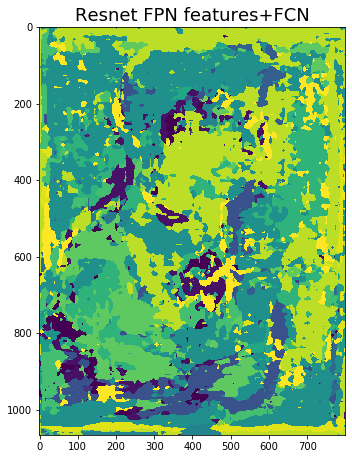

In [12]:
_, y_argmax = torch.max(seg_out, dim=1)
y_argmax = y_argmax.cpu()
seg_map = y_argmax.detach().numpy()
seg_map = np.squeeze(seg_map)
#plt.subplot(1,3,3)
plt.imshow(seg_map)
plt.title('Resnet FPN features+FCN', size=18)

Text(0.5, 1.0, 'Resnet FPN features+FCN')

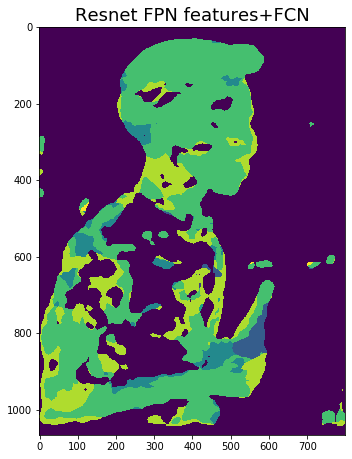

In [55]:
_, y_argmax = torch.max(seg_out, dim=1)
y_argmax = y_argmax.cpu()
seg_map = y_argmax.detach().numpy()
seg_map = np.squeeze(seg_map)
#plt.subplot(1,3,3)
plt.imshow(seg_map)
plt.title('Resnet FPN features+FCN', size=18)